# Returning Prediction Uncertainty in Regression Models. Tutorial. 

## Motivation: yhat is not enough

As Data Scientists in a bank, we usually deal with regression or forecasting problems: forecast the expenses of a customer in the next month, forecast the balance of a customer given the last transactions, predict savings, predict prices of flats or cars, predict the profitability of a customer.

These are tasks where we have to estimate a single output variable  $y$  given a set of input values (or a series)  $x$ .

Normally, we fit a model, and then at runtime we do `yhat = model.predict(x)`.

The problem is that this outputs a single scalar and we do not have any notion of how confident the prediction is. If my model says "Customer will save 632.34 Euros", how confident is the model? Does the model mean that the customer will save *exactly* that amount? Or does the model have an estimation about how much the savings can deviate from 632.34?"

**The question is:** Do we have ways to output a prediction interval? (e.g. is it 630-640 or rather 600-700)?

## This notebook

Using a simple linear regression example, but using input-dependent noise, we will discuss the following: 

* Understand why constant input-dependent uncertainty can be useful
* Discuss methods to achieve input-dependent uncertainty: 
 * Heteroscedastic network
 * Quantile regression network
 * UMAL (Uncountable mixture of Asymmetric Laplacians). 
 
The example is simple on purpose (in order to concentrate on the techniques), but these methods have been tested both in account expense forecasting and balance forecasting with millions of samples (see [this presentation](https://docs.google.com/presentation/d/1IYJyafGGB6P8yk2YCRisP4DvPIRIZNvfJRiSZJCpIO8/edit)). Just ask the authors or see the links section at the end of the notebook. We are also happy to assist you in testing these methods on your own data. 

## Baseline: Linear regression recap

First, let's set up the task: linear regression with input dependent noise. 

### Data preparation
We prepare a dataset to illustrate a Linear Regression problem (with input-dependent noise). 

In [0]:
import numpy as np
np.random.seed(42)

# Function that generates a dataset of given number of points in the range x=[low, high]
def generate_set(points, low, high):
    
    X_train = np.random.uniform(low=low,high=high,size=(points))

    std = 0.4
    epsilon = np.random.normal(0,std,size=(points))

    def f(x):
        a_0 = -9.3
        a_1 = 3.5
        return a_0+x*a_1

    y_train = f(X_train)+epsilon+[np.random.normal(0,i) for i in (np.sin(X_train*-10))+1]
    norm_value = np.abs(y_train).max()
    y_train = y_train/norm_value

    return X_train, y_train

Given the above function, we prepare training and test datasets: 

In [0]:
# Generate training ant test: 
from sklearn.model_selection import train_test_split

X, y = generate_set(50000, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

And plot them (we plot a subset of points for clarity). 

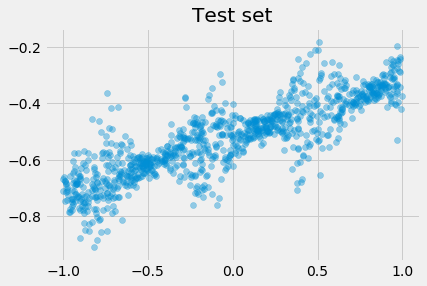

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
rp = np.random.permutation(X_train.shape[0])[:1000]

# Plot
plt.scatter(X_test[rp], y_test[rp], alpha=0.4)
_ = plt.title("Test set")

As we can see, points are generated from a line with input-dependent noise (some regions are more noisy than others). This is a simplified example, but imagine you want to predict the price of an apartment from some attributes, and in some neighborhoods the price fluctuates more than in others; we would be in a similar situation. 

Now let's see how a linear regression performs here. 

### Linear Regression

We fit a linear regression -- let's use the vanilla sklearn one which uses ordinary least squares (OLS). First, let's look at the mean prediction. It will become interesting when we add the input-dependent noise. 

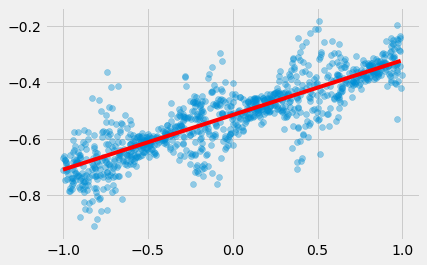

In [0]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train[:,None], y_train)

Xv = np.arange(-1, 1, 0.01)[:,None]
yhatv = lr.predict(Xv)

# Correct estimator for sigma: 
yhat_train = lr.predict(X_train[:,None])

plt.scatter(X_test[rp], y_test[rp], alpha=0.4)
plt.plot(Xv, yhatv, 'r', linewidth=4)

Linear regression predicts an output $y$ given an $x$, by fitting a line that minimizes the sum of squared distances to between the $y$ and the line.  *(It turns out this is equivalent to fitting a probability distribution $p(y|x$) and finding the most probable $y$'s for each $x$. You can read more about this in Bishop's Pattern Recognition and Machine Learning book)*. 

But note how knowing $\hat{y}$ alone lacks important information: we might need to know how far the true $y$ can be from the expected $\hat{y}$ value. *(Imagine you want to predict the price of a flat from some attributes and the regression outputs 123,246.73. We may be more interested in a range than in a single value with decimal precision. For example, in neighborhoods where prices have a low fluctuation the predicted interval could be between 118,000 and 128,000, while in neighborhoods where prices have a high fluctuation the predicted interval could be between 98,000 and 148,000")*. 

The variance estimator of OLS can be easily computed, and confidence interval plotted: 

sigma = 0.07054741389084589


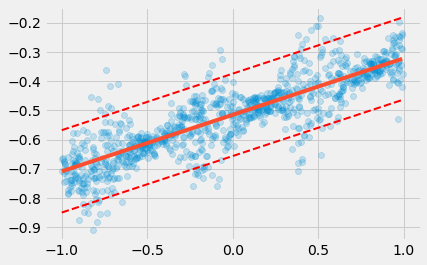

In [0]:
# Std of OLS is the std of distances
sigma = np.sqrt(np.square(yhat_train-y_train).mean())
print("sigma =", sigma)

plt.plot(X_test[rp],y_test[rp],'o', alpha=0.2)
plt.plot(Xv, yhatv, linewidth=4)
plt.plot(Xv, yhatv-2*sigma, 'r--', linewidth=2)
plt.plot(Xv, yhatv+2*sigma, 'r--', linewidth=2)
plt.show()

Now we have a range (which is better). The range is well-calibrated (exercise: check that about 96% of the points fall inside ($\hat{y} \pm 2*\sigma$)). The problem, however, is that this interval is constant!

This is because ordinary least squares regression assumes a constant noise (statisticians call this constant noise term "homoscedastic"). 

**Now we will see deep methods that allow outputting input-dependent noise.**

## Method 1: Heteroscedastic networks

Ordinary least squares is equivalent to finding a (linear) function $\hat{y} = \phi(x; W)=w_1x_1 + \ldots w_Dx_D$, such that the weights $W$ and the constant $\sigma$ maximize the log-likelihood $log \mathcal{L} = \sum \mathcal{N} (x | \phi(x; W), \sigma)$ (Bishop, 2006).

Here, we can make $\sigma$ depend on the input easily, by parametrizing it as a function $\sigma = \psi(x; W')$. The function $\psi$ probably needs to be non-linear in order to be able to fit complex dependencies of $x$. 

To fit both the regression line and the sigma function, we must jointly find the weights $W$ and $W'$ that maximize the log-likelihood $log \mathcal{L} = \sum \mathcal{N} (x | \phi(x; W), \psi(x; W')$.

One way to implement this model is to consider a neural network, that takes $x$ as input, and has two outputs:  $\hat{y} = \phi(x)$, $\hat{\sigma}=\psi(x)$. Then one can optimize the weights of the network to maximize

\begin{equation}
log \mathcal{L} = \sum \mathcal{N} (x | \hat{\mu}, \hat{\sigma}) \qquad (1)
\end{equation}

The advantage of neural networks is that, by using mutiple layers and non-linear activation functions, one can model non-linear relationships between the input $x$ and $\hat{\mu}, \hat{\sigma}$.

The blocks below show an implementation of this idea. 

We'll use a `tensorflow` implementation. First we prepare the tensorflow-ware:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers import Input
from keras import backend as K
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.engine.topology import Layer
import tensorflow as tf

import tensorflow as tf
sess = tf.InteractiveSession()

K.set_session(sess)

Using TensorFlow backend.


Next we define the loss function: 

In [0]:
# Log of Gaussian likelihood
def log_normal_pdf(y, output_psi, epsilon):
    return -tf.log(epsilon)-(K.square(y-output_psi)/(2.*K.square(epsilon)))

# This is the expression corresponding to Equation (1) above! 

# Log-likelihood is negative because it is a fitness function (positive is better)
# and here it is taken as a loss function (negative is better). 
def regression(y_true, parameters):
    mu = parameters[:,:-1]
    sigma = parameters[:,-1:]
    return -K.sum(log_normal_pdf(y_true[:,:1],mu,sigma))

from keras.layers import ELU

def elu_plus1(x, a=1.):
    return ELU(alpha=a)(x)+1.

The next cell defines the neural networks that implement $\phi$ and $\psi$ and links them with the loss function defined above. 

Note that $\phi$ is still linear, so we still do a linear regression. **But $\psi$ is a 3-layer network, so $\sigma$ now depends on x, and in a non-linear way**. 

In [0]:
i = Input(name='input', shape=(1,), dtype='float32')

phi = Dense(units=1, activation="linear", name='w',
              kernel_initializer='ones')(i)

psi = Dense(units=120, activation="sigmoid", name='v_0')(i)
psi = Dense(units=12, activation="sigmoid", name='v_1')(psi)
psi = Dense(units=1, activation=elu_plus1, name='v_2')(psi)

model = Model(
    inputs=[i],
    outputs=[concatenate([phi,psi],  
                         axis=1, 
                         name='main_output')])

opt = Adam(lr=0.005)
model.compile(optimizer=opt, loss={'main_output':regression})

Push the button. 

We will run this for a few epochs and save the predictions at each epoch, to inspect the evolution. 

In [0]:
%%time

from tqdm import tqdm
predictions = []
predictions_full = []

# First time, predict with uninitialized model
prediction = model.predict(Xv)
predictions.append(prediction)

prediction_full = model.predict(X_test)
predictions_full.append(prediction_full)
    
for it in tqdm(np.arange(10)):

    history = model.fit(X_train.reshape(-1,1), 
                      y_train.reshape(-1,1),
                        batch_size=100,
                        epochs=100, validation_split=0.1,verbose=0)

    prediction = model.predict(Xv)
    predictions.append(prediction)

    prediction_full = model.predict(X_test)
    predictions_full.append(prediction_full)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [06:17<00:00, 37.56s/it]

CPU times: user 8min 33s, sys: 17 s, total: 8min 51s
Wall time: 6min 18s


Now that the model is trained, let's plot the predicted line, and confidence bars for each x. 

<ErrorbarContainer object of 3 artists>

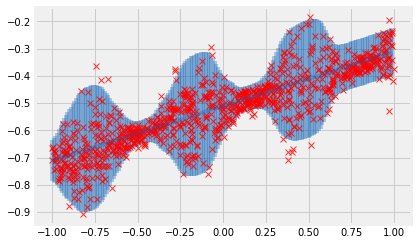

In [0]:
plt.plot(X_test[rp], y_test[rp],'x',c='r',
                 alpha=0.8, label='real generated data')


plt.errorbar(Xv,predictions[-1][:,0],
                     yerr=2*predictions[-1][:,1],
                     color='#0A5FB4',
                     alpha=0.3,
                     label='prediction')


**In contrast with the previous fitted linear regression, now the confidence intervals vary with the input. We can see how effectively the confidence interval is higher on those regions where the output has higher uncertainty!**

If we inspect the model for some specific epochs, the confidence bars (corresponding to $2\sigma(x)$ should adjust progressively to the data (which seems to be the case). 

(-1, 0)

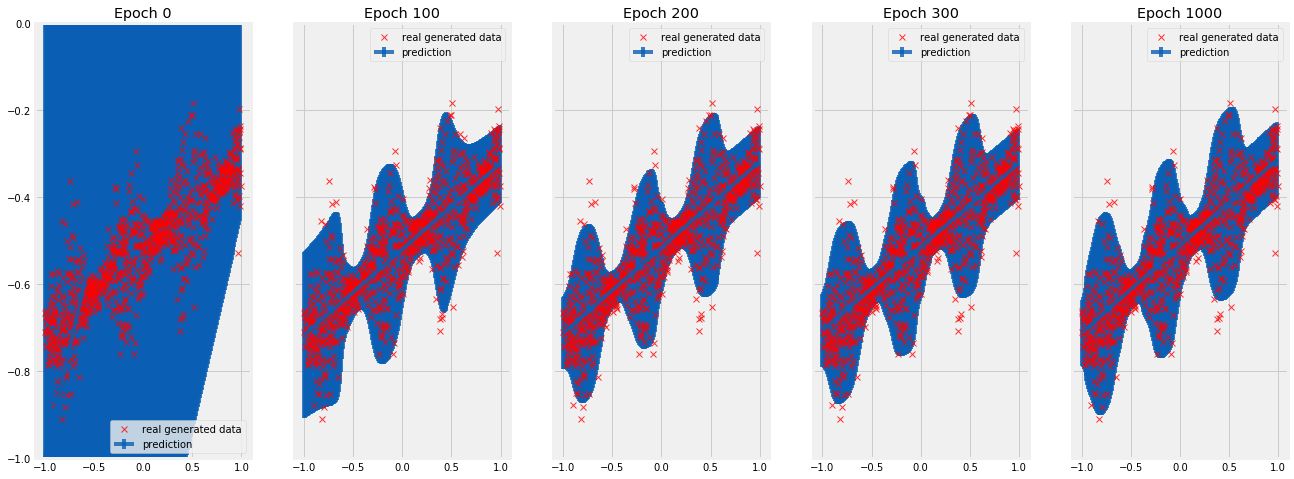

In [0]:
figure = plt.figure(figsize=(20, 8))
ax = figure.subplots(1, 5, sharey=True)

for i, f in enumerate([0, 1, 2, 3, 10]):
    ax[i].errorbar(Xv,predictions[f][:,0],
                     yerr=2*predictions[f][:,1],
                     color='#0A5FB4',
                     alpha=0.8,
                     label='prediction')

    ax[i].plot(X_test[rp], y_test[rp],'x',c='r',
                 alpha=0.8, label='real generated data')
    
    ax[i].legend()
    ax[i].set_title("Epoch " + str(100*f))
    
plt.ylim((-1, 0))

The next cells display calibration plots for the estimation of sigma. What is a calibration plot? 

Given a model that takes a test point $(x, y)$ and estimates $\hat{y}$ and $\sigma$, we can check if $y-N\sigma < \hat{y} < y + N\sigma$. We can compute the fraction of test points that accomplish this, for different values of $N$. Because $\hat{y}$ and $\sigma$ are the mean and std of a Normal distribution, we also know many points should accomplish this relation theoretically. So we can compare both quantities, and both should coincide. So if the plot is linear, we say the regression is well-calibrated. 

Let's implement this metric:

In [0]:
from scipy.stats import norm

def calibration_normal(y, yhat, sigma, eval_at=np.array([1,2,3])):
    
    real_p = np.empty_like(eval_at, dtype=float)
    rv = norm(loc=0, scale=1)
    expected_p = rv.cdf(eval_at) - rv.cdf(-eval_at)
    
    for i,s in enumerate(eval_at):
        lower = yhat - s*sigma
        upper = yhat + s*sigma
    
        result = np.logical_and(y>=lower, y<=upper)
        real_p[i] = np.mean(result)
        
    return expected_p, real_p

And compute the calibration plot of the model that we have trained: 

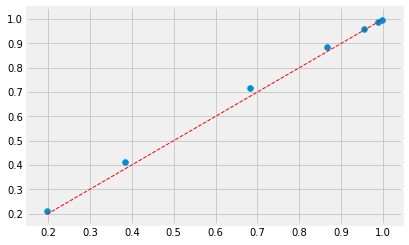

In [0]:
at = np.array([0.25, 0.5, 1, 1.5, 2, 2.5, 3])
exp_p, obs_p = calibration_normal(y_test, predictions_full[-1][:,0], predictions_full[-1][:,1], at)
plt.scatter(exp_p, obs_p)
plt.plot(exp_p, exp_p, 'r--', linewidth=1)

It seems fairly well-calibrated. If we compare to the calibration plot of a OLS, where $\sigma$ is constant: 

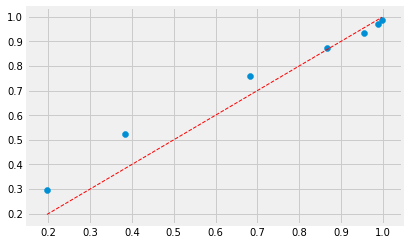

In [0]:
exp_p_lr, obs_p_lr = calibration_normal(y_test, lr.predict(X_test[:,None]), sigma, at)
plt.scatter(exp_p_lr, obs_p_lr)
plt.plot(exp_p, exp_p, 'r--', linewidth=1)

Here the calibration is a bit worse -- not surprisingly: OLS tries to model a non-constant std with a constant one. 

*Based on the article presented at Applied Data Science Track of The European Conference on Machine Learning and Principles and Practice of Knowledge Discovery in Databases (ECML-PKDD 2018)</h7> [arxiv link](https://arxiv.org/pdf/1807.09011.pdf)$|$[conference link](http://www.ecmlpkdd2018.org/wp-content/uploads/2018/09/227.pdf) and on the article titled as "When y_hat is not enough: Building uncertainty models on top of black-box predictive APIs" (under review)*

## Method 2: Quantile Regression

When we do linear regression with a sum-of-squared loss, the fitted line corresponds to the mean of the conditional distribution of the target variable given the input. By modifying the loss function, we can achieve other behaviours: for example, linear regression with sum-of-aboslute-differences estimates the median, i.e. the 50th-percentile. 

Similarly, there is a loss function, called pinball loss ([read more in this post](https://towardsdatascience.com/deep-quantile-regression-c85481548b5a)), which allows estimating the conditional quantiles:

\begin{equation}
 \mathcal{L}(\boldsymbol{x}, y, \tau) =
 \bigl(y - f_{\boldsymbol{w}}(\tau, \boldsymbol{x})\bigr) \cdot
 \bigl(\tau - \mathbb{1}{[y<f_{\boldsymbol{w}}(\tau, \boldsymbol{x})]} \bigr)
\end{equation}

Here, $\mathbb{1}{\left[c\right]}$ denotes the indicator function that
returns 1 if $c$ is true and 0 otherwise. This is an asymmetric convex
loss function that penalises overestimation errors with weight $\tau$
and underestimation errors with weight $1-\tau$. It turns out that the function $f_{\boldsymbol{w}}(\tau, \boldsymbol{x})$ minimizing this loss over a training set, will estimate the quantile $\tau$ of $y$ given $x$! 

**We could, for instance, ask to predict the 10-th and 90-th percentiles given the input; so we have an upper and lower 'uncertainty interval' for each $x$.** 

Below is an implementation taken from [this notebook](https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb). 

In [0]:
# Create network
class q_model:
    def __init__(self, 
                 sess, 
                 quantiles, 
                 in_shape=1, 
                 out_shape=1, 
                 batch_size=32):
        
        self.sess = sess
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        
        self.build_model()
        
    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE): 
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.layers.dense(self.x, 
                                    units=32, 
                                    activation=tf.nn.relu)
            self.layer1 = tf.layers.dense(self.layer0, 
                                    units=32, 
                                    activation=tf.nn.relu)

            # Create outputs and losses for all quantiles
            for i in range(self.num_quantiles):
                q = self.quantiles[i]
                
                # Get output layers 
                output = tf.layers.dense(self.layer1, 1, name="{}_q{}".format(i, int(q*100)))
                self.outputs.append(output)
                
                # Create losses
                
                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error), axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = tf.train.AdamOptimizer().minimize(self.combined_loss)

    def fit(self, x, y, epochs=100):  
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]),:]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]),:]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run([self.train_step, self.combined_loss], feed_dict)
                epoch_losses.append(c_loss)
                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 10 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))
            
    def predict(self, x):   
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = sess.run(self.outputs, feed_dict)
        
        return predictions

 Now let's fit the model. Now we ask to predict the median (quantile 0.5), as well as quantiles 0.1 and 0.9 to get the uncertainty interval. 

In [0]:
# Instantiate model
quantiles = [.1, .5, .9]
model = q_model(sess, quantiles, batch_size=32)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

epochs = 5
predictions_q = []
predictions_q.append(model.predict(Xv))

for i in range(4):
    model.fit(X_train[:,None], y_train[:,None], epochs)
    predictions_q.append(model.predict(Xv))

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 0: 0.08224085718393326
Epoch 0: 0.04965503513813019
Epoch 0: 0.04872730001807213
Epoch 0: 0.04842543974518776


Make the prediction: 

In [0]:
yhatv = model.predict(Xv)

Display the 3 quantiles

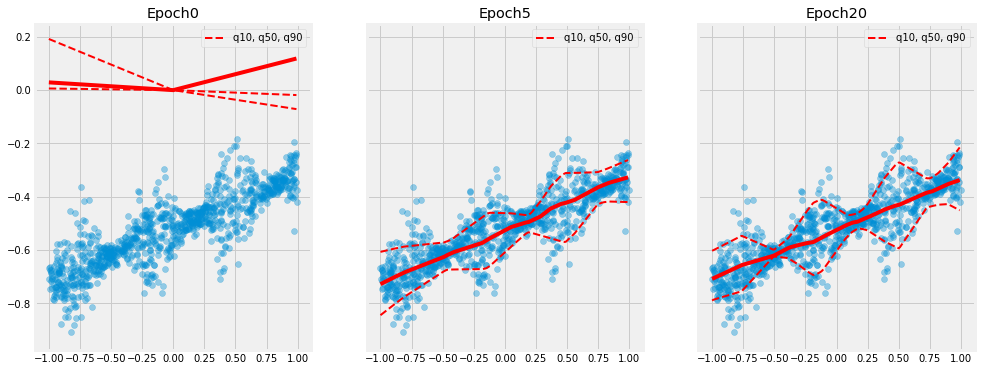

In [0]:
figure = plt.figure(figsize=(15,6))
ax = figure.subplots(1, 3, sharey=True)
for i,f in enumerate([0,1,4]): 
    ax[i].scatter(X_test[rp], y_test[rp], alpha=0.4)
    yhatv = predictions_q[f]
    ax[i].plot(Xv, yhatv[0], 'r--', linewidth=2)
    ax[i].plot(Xv, yhatv[1], 'r', linewidth=4)
    ax[i].plot(Xv, yhatv[2], 'r--', linewidth=2)
    ax[i].set_title("Epoch" + str(5*f))
    ax[i].legend(["q10, q50, q90"])

We see how at the end of the learning process, the quantiles also seem to adjusto to the data distribution. 
Knowing the conditional quantiles allows e.g. to output the most probable prediction (quantile .5), a prediction interval (e.g. quantiles 0.05 and 0.95) or detect outliers (e.g. observe new samples and check whether they lie above quantile .95 (or below 0.05). 

Drawbacks of quantile regression include: 

* Need 1 model (or at least one output) per quantile. 
* The "crossing quantiles" phenomenon: at runtime, there might be samples where the prediction for percentile 0.05 is higher than the prediction for 0.95. How to avoid this is still a problem in the quantile regression literature. 

The next model (UMAL) avoids these two problems. 

    

## Method 3: UMAL

UMAL is a method developed at BBVA D&A to estimate directly $p(y|x)$, i.e. the conditional distribution of a target variable given the input. Developed as part of the industrial PhD of Axel Brando. 

You can get started [in this BBVA repository](https://github.com/BBVA/UMAL). The following cells take code from that source. 

In a nutshell, we design a neural network which, in its last layer, learns the parameters of a distribution called "Uncountable Mixture of Asymmetric Laplacians". This mixture can fit any distribution, and it has connections with quantile regression as explained in the research paper (which is linked in the repository above). 

First, let's define the network architecture: 

In [0]:
#Definition of the hidden layers. These layers could be any desired layers 
# as long as they return the penultimate internal representation to predict
# the forecasted parameters of the ALD conditioned to tau.

from keras.layers import Activation

def hidden_architecture(i,name=""):
    model = Dense(units=120, activation="linear", name='FC0'+name)(i)
    model = Activation('relu')(model)
    
    model = Dense(units=60, activation="linear", name='FC1'+name)(model)
    model = Activation('relu')(model)
        
    model = Dense(units=10, activation="linear", name='FC2'+name)(model)
    model = Activation('relu')(model)
    
    return model

In [0]:
# You need to upload umal.py from https://github.com/BBVA/UMAL
# if you have an internet connection, uncomment the following line. 
# !wget https://raw.githubusercontent.com/BBVA/UMAL/master/umal.py
import sys
sys.path.append(".")
from umal import build_UMAL, elu_modif, calculate_distribution, np_log_sum_exp

--2020-02-07 15:06:35--  https://raw.githubusercontent.com/BBVA/UMAL/master/umal.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6191 (6.0K) [text/plain]
Saving to: ‘umal.py.1’

umal.py.1           100%[===================>]   6.05K  --.-KB/s    in 0s      

2020-02-07 15:06:35 (78.1 MB/s) - ‘umal.py.1’ saved [6191/6191]



Set up the UMAL model and fit it: 

In [0]:
syn_model = build_UMAL(input_size=1,learning_rate=1e-2, architecture=hidden_architecture,
                        b_act=lambda x: elu_modif(x,shift=1e-3))

K.set_value(syn_model.n_taus, 100)


losshistory = syn_model.fit(X_train[:,None],y_train[:,None], batch_size=100,
                            epochs = 10, initial_epoch=0, verbose=1,
                            validation_split=0.1, 
                            )

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 8s 346us/step - loss: -0.6846 - val_loss: -1.2043
Epoch 2/10
22500/22500 [==============================] - 8s 335us/step - loss: -1.2475 - val_loss: -1.2837
Epoch 3/10
22500/22500 [==============================] - 8s 336us/step - loss: -1.2518 - val_loss: -1.2983
Epoch 4/10
22500/22500 [==============================] - 7s 333us/step - loss: -1.2900 - val_loss: -1.2631
Epoch 5/10
22500/22500 [==============================] - 7s 291us/step - loss: -1.2766 - val_loss: -1.2673
Epoch 6/10
22500/22500 [==============================] - 7s 300us/step - loss: -1.2966 - val_loss: -1.3282
Epoch 7/10
22500/22500 [==============================] - 8s 338us/step - loss: -1.3222 - val_loss: -1.0408
Epoch 8/10
22500/22500 [==============================] - 7s 332us/step - loss: -1.2934 - val_loss: -1.3445
Epoch 9/10
22500/22500 [==============================] - 8s 335us/step - loss: -1.3498

Now at "test time", we can get the parameters of the ALD which represents $p(y|x)$ for each test point: 

In [0]:
syn_model_pred = build_UMAL(**{**syn_model._hp,'training':False})
try: 
    syn_model_pred.set_weights(syn_model.get_weights())
except ValueError: 
    syn_model_pred.set_weights(syn_model.get_weights()[1:])

In [0]:
sel_taus = np.arange(0.+5e-2,1.-5e-2,0.01)

# Predict for each input point the parameters of the selected conditioned ALDs 
#  identified by sel_taus
pred_tmp = sess.run(syn_model_pred.output, 
                    feed_dict={syn_model_pred.input: Xv,
                               syn_model_pred.taus:sel_taus}
                   ).reshape(-1,len(sel_taus),syn_model_pred.output.shape[-1]).transpose((1,0,2))

In [0]:
##Evaluate each ALD for a discretization of 1000 points over a certain desviation interval
dist, min_, max_, points = calculate_distribution(pred_tmp,1000,desv_from_minmax=30)

100%|██████████| 200/200 [00:06<00:00, 31.29it/s]


And now we can visualize the result on our task. 

In [0]:
norm_dist = np_log_sum_exp(dist,axis=-1).squeeze()-np.log(dist.shape[-1])

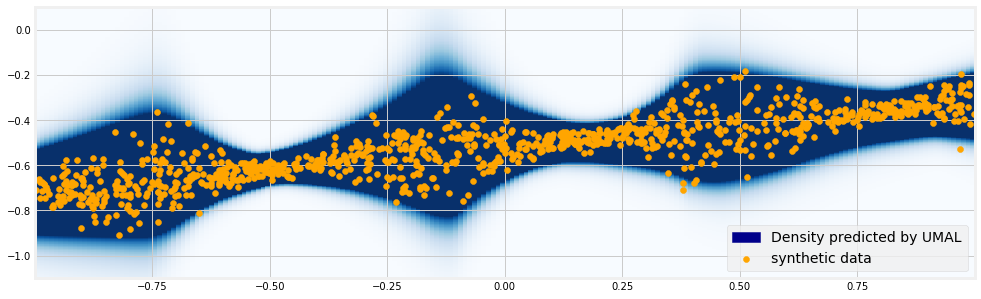

In [0]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(15., 5.))
        
plt.imshow(np.clip(np.flip(0.3*np.exp(norm_dist).T,axis=0),0.,0.05), 
           cmap=plt.cm.Blues, interpolation='nearest',
           extent=[X_test.min(),X_test.max(),min_,max_], aspect="auto")

sd = plt.scatter(X_test[rp], y_test[rp],c='orange', label='synthetic data')
        
patch = mpatches.Patch(color='darkblue', label='Density predicted by UMAL')       

lgnd = plt.legend(handles=[patch, sd],loc="lower right", fontsize=14)


plt.xlim(X_test.min(),X_test.max())
plt.ylim(y_test.min()-0.1,y_test.max()+0.1)
plt.show()

The shading represents $p(y|x)$ at each test point $x$. It seems to follow the shape of the data. The linked repository contains more examples. We have also applied it to a expense forecasting task (just ask us for details!). 

*Based on Axel Brando, Jose A. Rodriguez-Serrano, Jordi Vitria, Alberto Rubio. "Modelling heterogeneous distributions with an Uncountable Mixture of Asymmetric Laplacians." Advances in Neural Information Processing Systems. 2019.*